# 5. Influence factors: Vineyard management on berry microbiome

In [1]:
#!mkdir /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/management

In [2]:
workdir = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/influence/management'
%cd $workdir

/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/influence/management


In [3]:
%env TMPDIR=/scratch/lfloerl/tmpdata

env: TMPDIR=/scratch/lfloerl/tmpdata


In [4]:
from qiime2 import Visualization
import qiime2 as q2
from qiime2 import Visualization
from qiime2 import Artifact
from qiime2 import Metadata
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from qiime2.plugins.diversity.visualizers import alpha_group_significance
from qiime2.plugins.feature_table.methods import (filter_samples, filter_seqs)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats import f_oneway, chi2_contingency
import numpy as np

from qiime2.plugins import diversity as q2d

%matplotlib inline

# Colinearity between variables

In [56]:
md_df = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Management.tsv', sep='\t')
md_df.head()

,id,SAMPLE_NAME,sample_type,Plot_ID,COLLECTION_DATE,Year,Plot,Altitude,Average_slope,Exposition,...,Hydromorphie,Hydromorphie_code,Geology,Phenology_BudBreak,Phenology_Flowering,Hail_Damage,Herbicide,Mildew,Grape_Yield_Estimate,Pruning_Weight
0,364526_290-LP3-ITS-0866,Lavaux_2021-08-31_bark_Plot4,bark,Lavaux_Plot_4,2021-08-31 00:00:00 +0200,2021,4,450,30,South-West,...,Slightly_redox,1,Molasse,105,170,no,band,yes,medium,49.71
1,364526_289-LP3-ITS-0865,Lavaux_2021-08-31_bark_Plot5,bark,Lavaux_Plot_5,2021-08-31 00:00:00 +0200,2021,5,400,30,South-West,...,no_redox,0,Molasse,104,167,no,band,no,medium,57.41
2,364526_285-LP3-ITS-0861,Lavaux_2021-08-31_bark_Plot9,bark,Lavaux_Plot_9,2021-08-31 00:00:00 +0200,2021,9,520,35,South-West,...,no_redox,0,Molasse,111,172,no,almost_total,yes,low,38.99
3,364526_287-LP3-ITS-0863,Lavaux_2021-08-31_bark_Plot11,bark,Lavaux_Plot_11,2021-08-31 00:00:00 +0200,2021,11,490,20,South,...,Slightly_redox,1,Gravel_moraine,109,173,yes,band,yes,low,47.67
4,364526_282-LP3-ITS-0858,Lavaux_2021-08-31_bark_Plot12,bark,Lavaux_Plot_12,2021-08-31 00:00:00 +0200,2021,12,520,15,South-West,...,Slightly_redox,1,Colluvium,107,173,no,almost_total,yes,medium,54.09


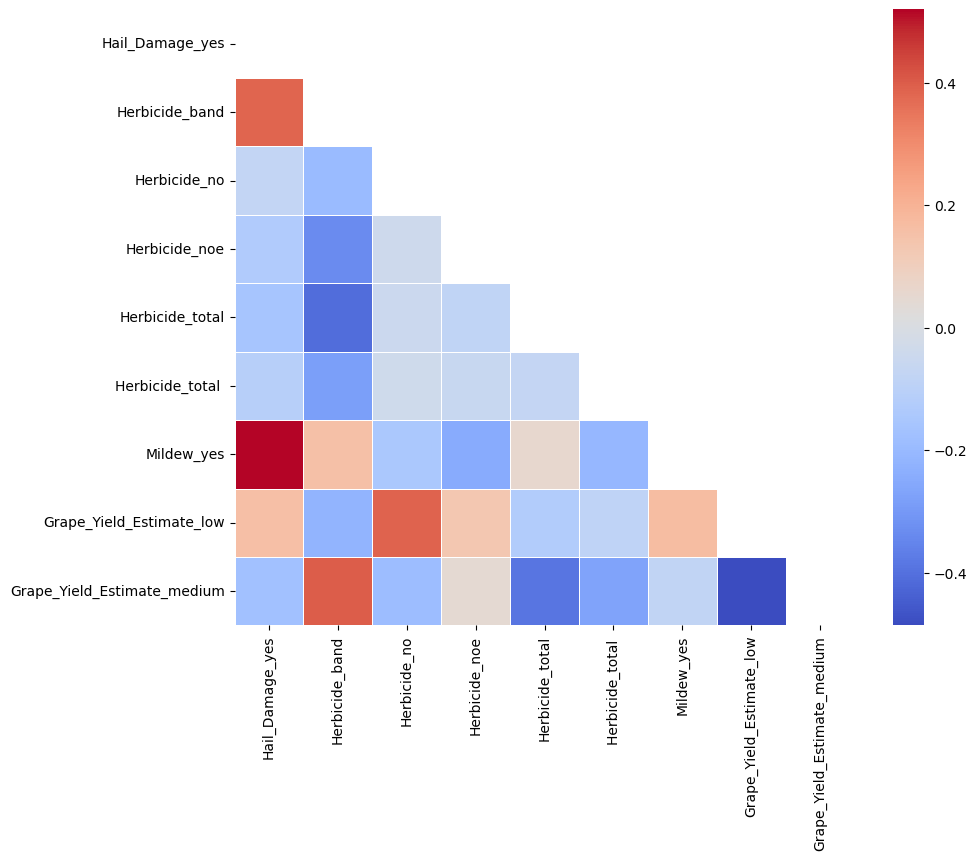

In [61]:
# Convert categorical variables to dummy variables
encoded_md = pd.get_dummies(md_df[['Hail_Damage', 'Herbicide', 'Mildew', 'Grape_Yield_Estimate']], drop_first=True)

# Compute and visualize correlation
cor_matrix = encoded_md.corr()

# Mask the upper triangle for clarity
mask = np.triu(np.ones_like(cor_matrix, dtype=bool))

# Set masked values to NaN for annotations
annot_matrix = cor_matrix.mask(mask)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, mask=mask, annot=annot_matrix, cmap='coolwarm',annot_kws={'size': 8}, fmt='.2f', cbar=True, linewidths=0.5)
plt.show()

> strong correlation between hail damage and mildew 

In [63]:
# Extract the two columns you want to compare
hail_damage = encoded_md['Hail_Damage_yes']
mildew = encoded_md['Mildew_yes']

# Perform one-way ANOVA
anova_result = f_oneway(hail_damage[hail_damage == 0], hail_damage[hail_damage == 1], mildew[mildew == 0], mildew[mildew == 1])

# Print the F-statistic and p-value
print("ANOVA F-statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

ANOVA F-statistic: inf
ANOVA p-value: 0.0


/scratch/lfloerl/.condaenvs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


In [66]:
# Create a contingency table
contingency_table = pd.crosstab(encoded_md['Hail_Damage_yes'], encoded_md['Mildew_yes'])

# Perform the Chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-Square Statistic:", chi2_stat)
print("p-value:", p_val)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:\n", expected)

Chi-Square Statistic: 158.394198942897
p-value: 2.5380914693392096e-36
Degrees of Freedom: 1
Expected Frequencies Table:
 [[252.78319328 226.21680672]
 [ 61.21680672  54.78319328]]


# Must 

In [6]:
%%bash 

mkdir management-on-berry
cd management-on-berry

# Core diversity metrics
qiime diversity core-metrics \
        --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_filtered_table.qza \
        --p-sampling-depth 5000 \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Management.tsv \
        --p-n-jobs 5 \
        --output-dir cm5000/

# Kmer diversity
qiime kmerizer core-metrics \
        --i-sequences /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_filtered_rep_seqs.qza \
        --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_filtered_table.qza \
        --p-sampling-depth 5000 \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Management.tsv \
        --p-n-jobs auto \
        --p-max-features 5000 \
        --output-dir kmer_cm5000/


Saved FeatureTable[Frequency] to: cm5000/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: cm5000/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: cm5000/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: cm5000/evenness_vector.qza
Saved DistanceMatrix to: cm5000/jaccard_distance_matrix.qza
Saved DistanceMatrix to: cm5000/bray_curtis_distance_matrix.qza
Saved PCoAResults to: cm5000/jaccard_pcoa_results.qza
Saved PCoAResults to: cm5000/bray_curtis_pcoa_results.qza
Saved Visualization to: cm5000/jaccard_emperor.qzv
Saved Visualization to: cm5000/bray_curtis_emperor.qzv
Saved FeatureTable[Frequency] to: kmer_cm5000/rarefied_table.qza
Saved FeatureTable[Frequency] to: kmer_cm5000/kmer_table.qza
Saved SampleData[AlphaDiversity] to: kmer_cm5000/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: kmer_cm5000/shannon_vector.qza
Saved DistanceMatrix to: kmer_cm5000/jaccard_distance_matrix.qza
Saved DistanceMatrix to: kmer_cm5000/bray_curtis_distance_mat

## Alpha Diversity

In [14]:
alpha_metrics = ['shannon_vector', 'observed_features_vector', 'evenness_vector']

output_dir = 'management-on-berry/cm5000'

for metric in alpha_metrics:
    !qiime diversity alpha-group-significance \
        --i-alpha-diversity {output_dir}/{metric}.qza \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Management.tsv \
        --o-visualization {output_dir}/alpha_groupSig_{metric}.qzv

Saved Visualization to: management-on-berry/cm5000/alpha_groupSig_shannon_vector.qzv
Saved Visualization to: management-on-berry/cm5000/alpha_groupSig_observed_features_vector.qzv
Saved Visualization to: management-on-berry/cm5000/alpha_groupSig_evenness_vector.qzv


In [5]:
Visualization.load('management-on-berry/cm5000/alpha_groupSig_evenness_vector.qzv')

<visualization: Visualization uuid: 5b751559-6760-4ea5-b288-f239c8cd7efd>

In [6]:
Visualization.load('management-on-berry/cm5000/alpha_groupSig_observed_features_vector.qzv')

<visualization: Visualization uuid: adc774ba-95fe-41b3-8cfd-0af69ae420ca>

In [7]:
Visualization.load('management-on-berry/cm5000/alpha_groupSig_shannon_vector.qzv')

<visualization: Visualization uuid: ed59cc7b-43fd-4743-8888-3d6f66a43d9e>

### PERMANOVA thereof

In [77]:
#formula='Year + Phenology_BudBreak + Phenology_Flowering + Year:Hail_Damage + Herbicide + Mildew + Grape_Yield_Estimate + Pruning_Weight'

#formula='Year:Phenology_BudBreak + Year:Phenology_Flowering + Year:Hail_Damage + Year:Herbicide + Year:Mildew + Year:Grape_Yield_Estimate + Year:Pruning_Weight'

formula='Mildew * Hail_Damage'


beta_metrics = ['bray_curtis', 'jaccard']

# PERMANOVA with core metrics 
div_dir = 'cm5000'
for m in beta_metrics:
    !qiime diversity adonis \
        --i-distance-matrix "management-on-berry/{div_dir}/{m}_distance_matrix.qza" \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Management.tsv \
        --p-formula "{formula}" \
        --p-n-jobs 5 \
        --o-visualization "management-on-berry/{div_dir}/adonis_{m}.qzv"
    

# PERMANOVA with kmer core metrics 
kmer_dir = 'kmer_cm5000'
for m in beta_metrics:
    !qiime diversity adonis \
        --i-distance-matrix "management-on-berry/{kmer_dir}/{m}_distance_matrix.qza" \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Management.tsv \
        --p-formula "{formula}" \
        --p-n-jobs 5 \
        --o-visualization "management-on-berry/{kmer_dir}/adonis_{m}.qzv"

Saved Visualization to: management-on-berry/cm5000/adonis_bray_curtis.qzv
Saved Visualization to: management-on-berry/cm5000/adonis_jaccard.qzv
Saved Visualization to: management-on-berry/kmer_cm5000/adonis_bray_curtis.qzv
Saved Visualization to: management-on-berry/kmer_cm5000/adonis_jaccard.qzv


In [8]:
Visualization.load('management-on-berry/cm5000/adonis_bray_curtis.qzv')

<visualization: Visualization uuid: fc93e505-66f3-4080-9188-237afc915cad>

In [9]:
Visualization.load('management-on-berry/cm5000/adonis_jaccard.qzv')

<visualization: Visualization uuid: 3199a3ea-2535-4a74-bde4-7b77c11d3593>

In [10]:
Visualization.load('management-on-berry/kmer_cm5000/adonis_bray_curtis.qzv')

<visualization: Visualization uuid: 52c93579-4884-4cc5-9590-3471c74e8149>

In [11]:
Visualization.load('management-on-berry/kmer_cm5000/adonis_jaccard.qzv')

<visualization: Visualization uuid: 52e25113-dfe4-40aa-a0a2-3b63aff9846d>